Klassen: ['ABAP Dictionary', 'BW4Cockpit (Stammdaten)', 'Bewegungsdaten', 'Composite Provider', 'DTP', 'Data Flow Object', 'Data Mart', 'Data Source', 'Data Store Object', 'Datenvorschau', 'Excel', 'Query', 'Transformationen']


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/mambauser/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 115MB/s]  


Epoch 1/20 | Train Loss: 2.6826, Acc: 0.0716 | Val Loss: 2.5389, Acc: 0.1365
Epoch 2/20 | Train Loss: 2.5867, Acc: 0.0895 | Val Loss: 2.5576, Acc: 0.1275
Epoch 3/20 | Train Loss: 2.5792, Acc: 0.0761 | Val Loss: 2.5785, Acc: 0.0738
Epoch 4/20 | Train Loss: 2.5667, Acc: 0.0828 | Val Loss: 2.5038, Acc: 0.1163
Epoch 5/20 | Train Loss: 2.5166, Acc: 0.1253 | Val Loss: 2.5513, Acc: 0.0403
Epoch 6/20 | Train Loss: 2.5325, Acc: 0.0425 | Val Loss: 2.5392, Acc: 0.1096
Epoch 7/20 | Train Loss: 2.5952, Acc: 0.0559 | Val Loss: 2.5415, Acc: 0.0984
Epoch 8/20 | Train Loss: 2.5736, Acc: 0.0984 | Val Loss: 2.5438, Acc: 0.0358
Epoch 9/20 | Train Loss: 2.5887, Acc: 0.0694 | Val Loss: 2.5368, Acc: 0.0403
Epoch 10/20 | Train Loss: 2.5700, Acc: 0.0403 | Val Loss: 2.5017, Acc: 0.0403
Epoch 11/20 | Train Loss: 2.5363, Acc: 0.0425 | Val Loss: 2.5708, Acc: 0.0358
Epoch 12/20 | Train Loss: 2.5793, Acc: 0.0828 | Val Loss: 2.5463, Acc: 0.0716
Epoch 13/20 | Train Loss: 2.5694, Acc: 0.0783 | Val Loss: 2.5369, Acc: 0.

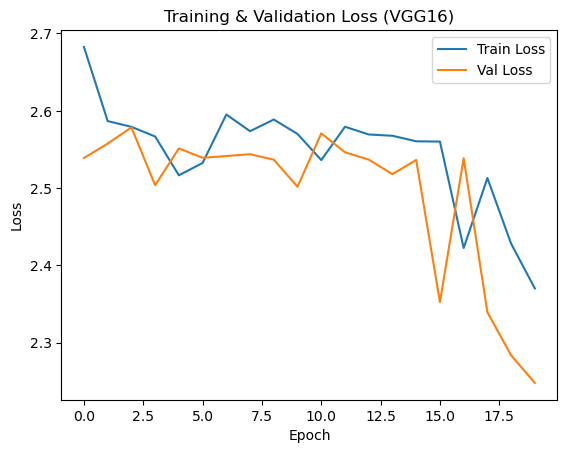

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt


data_root = Path("/workspace/Projekt/Testdaten/Data/SAP Bilder sortiert")

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


train_data = datasets.ImageFolder(data_root, transform=transform_train)
val_data   = datasets.ImageFolder(data_root, transform=transform_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)
print("Klassen:", train_data.classes)


weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

# Klassifikationskopf anpassen
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


class_counts = torch.tensor([len(list((data_root/cls).glob("*.*"))) for cls in sorted(train_data.classes)], dtype=torch.float)
weights = 1.0 / class_counts
weights = weights / weights.sum() * len(weights)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # kleinerer LR für VGG16


epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_acc:.4f}")


plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss (VGG16)")
plt.show()